In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

import my_utils as myf
import matplotlib.path as mpath
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh
from matplotlib.gridspec import GridSpec

import xesmf as xe

In [2]:
mydir = './data/sst_spatial_mean_trend/'
myfiles = [mydir+f for f in sorted(os.listdir(mydir)) if 'ocn_sst-trend-annmean.1979-2018' in f and 'HADISST' not in f]

In [3]:
# this is on original grid
obds = xr.open_dataset(mydir+'HADISST.ocn_sst-trend-annmean.1979-2018.nc')
obds = obds.rename({'latitude':'lat','longitude':'lon'})

In [4]:
listds = []
for file in myfiles: 
    ds = xr.open_dataset(file)
    if 'z_t' in ds:
        ds = ds.drop('z_t')
    ds = ds.squeeze()
    ds = ds.set_coords('names')
    
    # having problems with matplotlib and the CESM ocean lat lon coords
    # so I will regrid to HADISST grid for plotting
    ds = ds.rename({'TLAT':'lat','TLONG':'lon'})
    ds = ds.drop(['ULAT','ULONG'])
    regridder = xe.Regridder(ds, obds, 'bilinear', reuse_weights=True)
    ds = regridder(ds)
    listds.append(ds)
ds = xr.concat(listds,dim='names')

Reuse existing file: bilinear_384x320_180x360.nc
using dimensions ('nlat', 'nlon') from data variable SST_trend as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_384x320_180x360.nc
using dimensions ('nlat', 'nlon') from data variable SST_trend as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_384x320_180x360.nc
using dimensions ('nlat', 'nlon') from data variable SST_trend as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_384x320_180x360.nc
using dimensions ('nlat', 'nlon') from data variable SST_trend as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_384x320_180x360.nc
using dimensions ('nlat', 'nlon') from data variable SST_trend as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_384x320_180x360.nc
using dimensions ('nlat', 'nlon') from data variable SST_trend as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_384x320_180x360.

In [5]:
thenudge = ['anom_nudge_era_60','anom_nudge_era_60_archi','anom_nudge_era_60_arclo']
a60nudgemean = ds.isel(names=0).copy()
for var in ds:
    a60nudgemean[var] = ds[var].sel(names=thenudge).mean(dim='names')
a60nudgemean['names'] = 'aNUDGEmean'
a60nudgemean = a60nudgemean.set_coords('names')

thelens = [f for f in ds.names.values if 'LENS' in f]
lensmean = ds.sel(names=thelens).mean(dim='names')
lensmean['names'] = 'LENSmean'
lensmean = lensmean.set_coords('names')

In [6]:
ds = xr.concat([ds,a60nudgemean, lensmean,obds],dim='names')

In [7]:
mynames = ['HADISST','LENSmean','aNUDGEmean']

In [8]:
lat1, lat2 = 50, 55
lon1, lon2 = 325, 335

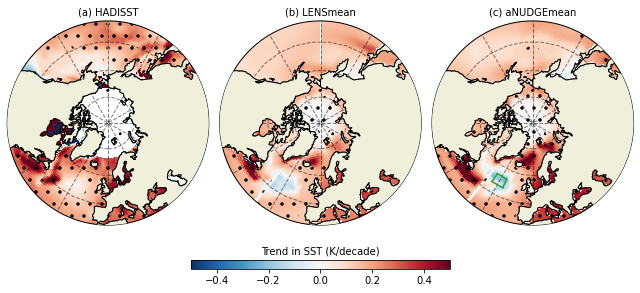

In [9]:
fig = plt.figure(figsize=(9,4))

for n, name in enumerate(mynames):
    ax = fig.add_subplot(1,3,n+1, projection = ccrs.NorthPolarStereo())
    ax.set_extent([0.005, 360, 35,90], crs=ccrs.PlateCarree())
    label = ['a','b','c','d','e','f'][n]
    ax.set_title('('+str(label)+') '+name,fontsize=10,loc='center')
    
    dmeridian = 30  # spacing for lines of meridian
    dparallel = 15  # spacing for lines of parallel 
    num_merid = int(360/dmeridian + 1)
    num_parra = int(90/dparallel + 1)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), \
                      xlocs=np.linspace(0, 360, num_merid), \
                      ylocs=np.linspace(0, 90, num_parra), \
                      linestyle="--", linewidth=1, color='k', alpha=0.5)

    theta = np.linspace(0, 2*np.pi, 120)
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    center, radius = [0.5, 0.5], 0.5
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)  #without this; get rect bound
    ax.coastlines()
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
  

    mydata = 10.*ds.SST_trend.sel(names=name)
    mypval = ds.SST_p_value.sel(names=name)
    if name=='HADISST':
        mydata = mydata.where(mydata.lat<70)
        mypval = mypval.where(mydata.lat<70)

    CS1 = ax.pcolormesh(mydata.lon,mydata.lat, mydata, vmax = .5, vmin=-.5, cmap = plt.cm.RdBu_r,
                    transform=ccrs.PlateCarree())
    stip = plt.contourf(mydata.lon,mydata.lat, mypval, levels = [0.,5.], 
                        transform=ccrs.PlateCarree(), colors=['none'], hatches=['.'])
       
ax.plot([lon1, lon2], [lat1, lat1], transform=ccrs.PlateCarree(),c='tab:green')
ax.plot([lon1, lon2], [lat2, lat2], transform=ccrs.PlateCarree(),c='tab:green')
ax.plot([lon1, lon1], [lat1, lat2], transform=ccrs.PlateCarree(),c='tab:green')
ax.plot([lon2, lon2], [lat1, lat2], transform=ccrs.PlateCarree(),c='tab:green')

plt.tight_layout()
plt.subplots_adjust(bottom = .05)
cbar_ax = fig.add_axes([0.3, 0.0, 0.4, 0.03]) #[left, bottom, width, height]
cbar = fig.colorbar(CS1, cax=cbar_ax,  orientation='horizontal')
cbar.ax.set_title('Trend in SST (K/decade)',fontsize=10)
fig.savefig('figs/sst_trend_a.pdf', dpi=500, bbox_inches='tight')
plt.show()
plt.close()

In [10]:
mydir = './data/sst_natl_timeseries/'
myfiles = [mydir+f for f in sorted(os.listdir(mydir))]

In [11]:
listds = []
for file in myfiles: 
        sstavgds = xr.open_dataset(file).squeeze()
        listds.append(sstavgds)
sstavgds = xr.concat(listds,dim='names')

thelens = [f for f in sstavgds.names.values if 'LENS' in f]
lensmean = sstavgds.isel(names=0).copy()
for var in sstavgds:
    lensmean[var] = sstavgds[var].sel(names=thelens).mean(dim='names')
lensmean['names'] = 'LENSmean'
lensmean =lensmean.set_coords('names')

sstavgds = xr.concat([sstavgds,lensmean],dim='names')

In [12]:
lineplotprop = myf.set_line_prop(sstavgds.names.values)

In [13]:
slope, intercept, r_value, p_value, std_err = myf.linregress(sstavgds.SST.groupby('time.year').mean(dim='time').year,
                                                             sstavgds.SST.groupby('time.year').mean(dim='time').load(), dim='year')

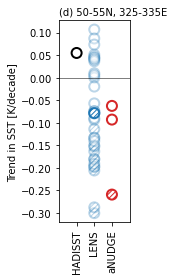

In [14]:
xlabels = ['HADISST','LENS','aNUDGE']

fig,ax = plt.subplots(1,figsize=(2,4))
for n, name in enumerate(slope.names.values):
    mk = ''
    if p_value.sel(names=name)<0.05:      
        mk= '/////'
    if 'LENS' in name:
        ax.scatter(2,10.*slope.sel(names=name), s=100., facecolor = 'white', edgecolors=lineplotprop[name]['c'], alpha=lineplotprop[name]['alpha'], hatch=mk, linewidth=2)
    elif '60' in name:
        ax.scatter(3,10.*slope.sel(names=name), s=100., facecolor = 'white', edgecolors=lineplotprop[name]['c'], alpha=lineplotprop[name]['alpha'], hatch=mk, linewidth=2)
    else:
        ax.scatter(1,10.*slope.sel(names=name), s=100., facecolor = 'white', edgecolors=lineplotprop[name]['c'], alpha=lineplotprop[name]['alpha'], hatch=mk, linewidth=2)

ax.set_xticks([1,2,3])
ax.set_xticklabels(xlabels,rotation='vertical')
ax.set_ylabel('Trend in SST [K/decade]')
ax.set_xlim([0,4])
ax.axhline(y=0,c='k',linewidth=.5)
ax.set_title('(d) '+str(lat1)+'-'+str(lat2)+'N, '+str(lon1)+'-'+str(lon2)+'E' ,fontsize=10,loc='left')
plt.tight_layout()
fig.savefig('figs/sst_trend_b.pdf', dpi=500, bbox_inches='tight')
plt.show()
plt.close()

In [15]:
np.count_nonzero(slope.sel(names=[f for f in slope.names.values if 'LENS' in f and 'mean' not in f]).values<0.)

23